In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
from vvasp.VizClasses import NeuropixelsChronicHolder
from vvasp.atlas_utils import Atlas as VvaspAtlas
import pyvista as pv
from labdata.schema import *
from labdata import chronic_paper as cp

[2024-06-10 11:25:50,525][INFO]: Connecting mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-10 11:25:51,055][INFO]: Connected mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [32]:
(cp.ChronicInsertion() & 'subject_name="JC162"')#.delete()
#(ProbeInsertion() & 'subject_name="JC118"')#.delete()

subject_name unique mouse id,procedure_type Defines procedures that are not an experimental session,procedure_datetime,probe_id probe id to keep track or re-uses,holder_id
JC162,chronic implant,2024-04-06 14:00:00,22420006801,2
JC162,chronic implant,2024-04-06 14:00:00,22420007684,3


In [16]:
from labdata.schema import *

subject = 'JC118'
#targets = [['ACA','MOs'], ['CP'], ['VISam','LP'],['VISp']]
#holder_ids = [3,2,2,3]
#hemispheres = [['left','left'],['left'],['left','left'],['left']]
targets = [['LP'],]
holder_ids = [2]
hemispheres = [['left'],]

sdict = dict(subject_name=subject,
             procedure_type='chronic implant')
keys = (ProbeInsertion() & sdict).proj().fetch(as_dict=True, order_by='insertion_ap')[::-1]
for hems, targs, id, key in zip(hemispheres, targets, holder_ids, keys):
    key['holder_id'] = id
    #cp.ChronicInsertion.insert1(key, skip_duplicates=True)
    #(cp.ChronicInsertion & key).delete()
    for h,targ in zip(hems,targs):
        key['region_acronym'] = targ
        key['atlas_id'] = 'allen-ccf'	
        #key['hemisphere'] = hemisphere
        key['hemisphere'] = h
        print(key)
        #cp.ChronicInsertion.TargetedRegion().insert1(key, skip_duplicates=True, ignore_extra_fields=True)


{'subject_name': 'JC118', 'procedure_type': 'chronic implant', 'procedure_datetime': datetime.datetime(2023, 9, 11, 15, 30), 'probe_id': '20403312442', 'holder_id': 2, 'region_acronym': 'LP', 'atlas_id': 'allen-ccf', 'hemisphere': 'left'}


In [4]:
cp.ChronicInsertion & dict(subject_name='MM011')
cp.ChronicHolderType()

holder_id,description
0,NP1 head fixed
1,NP1 freely moving
2,NP24 head fixed
3,NP24 freely moving
4,NP24alpha head fixed
5,NP24alpha freely moving


In [38]:
subjects

array(['JC118', 'JC119', 'JC131', 'JC140', 'JC141', 'JC142', 'JC162',
       'JC164', 'MM008', 'MM009', 'MM010', 'MM011', 'MM012', 'MM013',
       'MM015', 'MM018'], dtype=object)

In [49]:
probe_ids = (ProbeInsertion & f'subject_name = "MM012"').fetch('probe_id')
probe_ids = "\n".join(probe_ids)
print(probe_ids)

19454421152
20097916182
20097916222


In [87]:
#plotter = pv.Plotter(notebook=True)
#plotter.show()
import cv2
from pathlib import Path
from pyvistaqt import BackgroundPlotter
from tqdm import tqdm
plotter = BackgroundPlotter()
savedir = Path(r'C:\Data\churchland\chronic_manuscript_figs\raw_plots\trajectories')
subjects = np.unique(cp.ChronicInsertion().fetch('subject_name', order_by='procedure_datetime'))
ids, imgs = [],[]
for subj2plot in tqdm(subjects):
    insertions = ProbeInsertion * cp.ChronicInsertion() & f'subject_name = "{subj2plot}"'
    insertions = insertions.fetch(as_dict=True)
    probe_ids = (ProbeInsertion & f'subject_name = "{subj2plot}"').fetch('probe_id')
    probe_ids = "\n".join(probe_ids)
    ids.append(probe_ids)

    regions_to_show = cp.ChronicInsertion().TargetedRegion() & f'subject_name = "{subj2plot}"'
    regions_to_show = regions_to_show.fetch('region_acronym','hemisphere', as_dict=True)
    atlas = VvaspAtlas(plotter, min_tree_depth=6, max_tree_depth=8)
    for region in regions_to_show:
        atlas.add_atlas_region_mesh(region['region_acronym'], region['hemisphere'], force_replot=True)

    prbs = []
    for i, entrypoint in enumerate(insertions):
        entry_point = [entrypoint['insertion_ml'], entrypoint['insertion_ap']]
        depth = entrypoint['insertion_depth']
        angles = [entrypoint['insertion_el'], entrypoint['insertion_spin'], entrypoint['insertion_az']]
        if entrypoint['holder_id'] == 0:
            prb = NeuropixelsChronicHolder('NP1','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 1:
            prb = NeuropixelsChronicHolder('NP1','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 2:
            prb = NeuropixelsChronicHolder('NP24','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 3:
            prb = NeuropixelsChronicHolder('NP24','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 4:
            prb = NeuropixelsChronicHolder('NP24a','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 5:
            prb = NeuropixelsChronicHolder('NP24a','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        else:
            raise ValueError('Holder ID not recognized')

        prb.drive_probe_from_entry(entry_point, angles, depth)
        prb.make_inactive()
        prbs.append(prb)

    plotter.isometric_view()
    plotter.view_yz()
    #plotter.camera.position = np.array(plotter.camera.position) * .8 - np.array([-10000,0,36000])
    #plotter.camera.position = np.array(plotter.camera.position) * .7 - np.array([0,0,10000])
    plotter.camera.position = np.array(plotter.camera.position) * .7 - np.array([0,0,30000])
    #plotter.camera.position = (48743.171132539625, 37047.24303377419, 14626.300531977657)
    #plotter.camera.focal_point = (-5529.047647635011, -7648.9577710917965, 9324.864101662535)
    #print(plotter.camera.position)
    #print(plotter.camera.focal_point)
    img = plotter.screenshot(savedir / f'{subj2plot}_trajectories.png', return_img=True, scale=5)
    #font_scale = 100
    #font_color = (0,0,0)
    #font_thickness = 2
    #position = (0,0)
    #img = cv2.putText(img.copy(), subj2plot, position, cv2.FONT_HERSHEY_SIMPLEX , font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)
    imgs.append(img)

100%|██████████| 16/16 [01:24<00:00,  5.30s/it]


In [88]:
#plotter.save_graphic(savedir / f'{SUBJECT}_trajectories.pdf', raster=False)
def tile_images(image_list, grid_size):
    """
    Tiles a list of RGB images into a single image.
    
    :param image_list: List of RGB images (as numpy arrays).
    :param grid_size: Tuple (rows, cols) indicating the grid size.
    :return: Tiled image as a numpy array.
    """
    rows, cols = grid_size
    #assert len(image_list) == rows * cols, "Number of images does not match grid size"

    # Get the shape of the images
    img_height, img_width, img_channels = image_list[0].shape

    # Create an empty array for the tiled image
    tiled_image = np.zeros((rows * img_height, cols * img_width, img_channels), dtype=np.uint8) + 255

    # Populate the tiled image
    origins = []
    for idx, img in enumerate(image_list):
        row_idx = idx // cols
        col_idx = idx % cols
        tiled_image[row_idx * img_height:(row_idx + 1) * img_height,
                    col_idx * img_width:(col_idx + 1) * img_width, :] = img
        origins.append((row_idx * (img_height) + img_height, col_idx * img_width))

    return tiled_image, origins

im,origins = tile_images(imgs, (4,4))

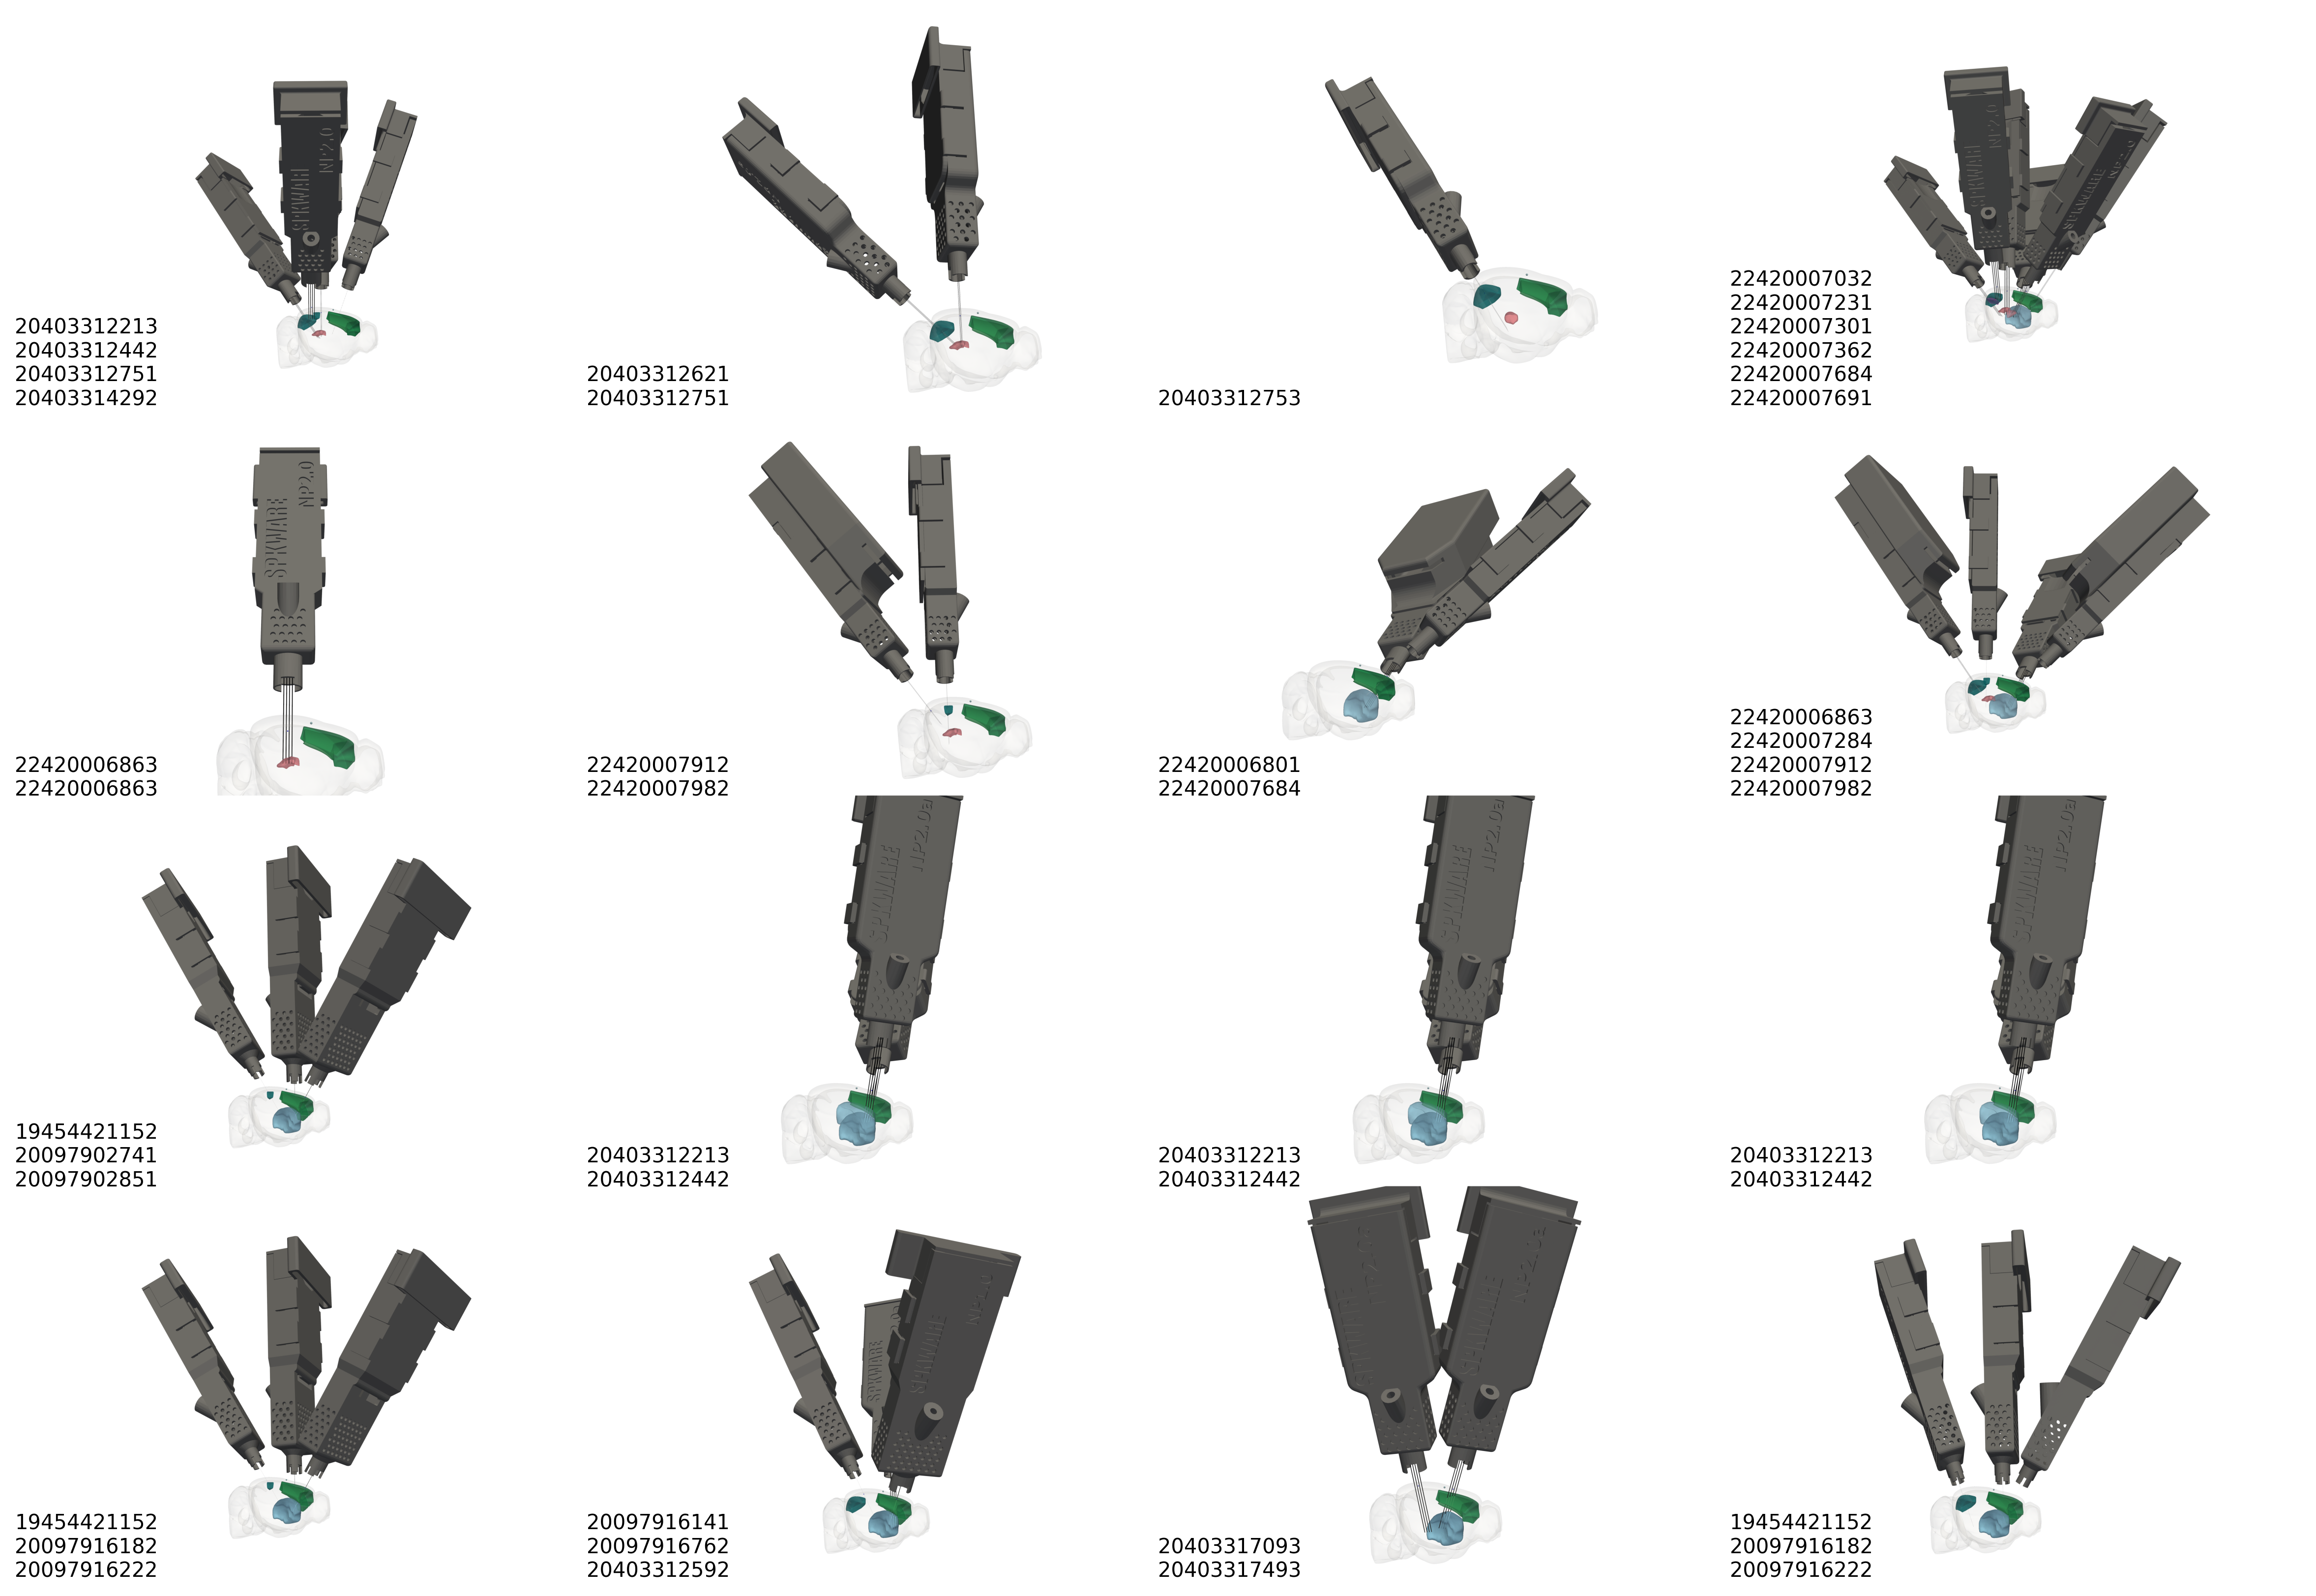

In [89]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(20,30), dpi=300)
#plt.figure(figsize=(20,30), dpi=20)
plt.axis('off')
plt.imshow(im)
for s, o in zip(ids,origins):
    nlines = len(s.split('\n'))
    ff = plt.text(o[1], o[0], s, fontsize=10, color='black')
#plt.savefig(savedir / 'all_trajectories.pdf', format='pdf', dpi=300, bbox_inches='tight')
#plt.savefig(savedir / 'all_trajectories.png', format='png', dpi=300, bbox_inches='tight')
plt.show()